Documentación pyedflib: https://pyedflib.readthedocs.io/en/latest/ref/edfreader.html

Documentación networkx: https://networkx.org/documentation/networkx-1.9/reference/index.html

Documentación csv: https://docs.python.org/3/library/csv.html

Información grafos: https://www.cienciadedatos.net/documentos/pygml01-introduccion-grafos-redes-python.html

Información igraph: https://igraph.org/python/tutorial/0.9.6

In [21]:
import pandas as pd
import numpy as np
import pyedflib
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from os.path import basename
from scipy.sparse._csr import csr_matrix # Se usa unicamente para describir el tipo de objeto del mst
from scipy.sparse.csgraph import minimum_spanning_tree
import igraph as ig
from pprint import pprint

CHANNELS: tuple[str] = ('Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 
                        'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 
                        'Fz', 'Cz', 'Pz')
N_CHANNELS: int = len(CHANNELS)

path: str = 'Archivos\\Subject00\\csv\\Subject00_1.csv'

# Obtiene la posicion del nombre del archivo en path y se hace un nuevo string que vaya desde 0 hasta esa posicion
path_without_filename: str = path[:path.find(basename(path))]

In [22]:
# Convertir un archivo EDF a CSV

def edf_to_csv(filename: str, output_path: str = '') -> None:
    # Se guardan los archivos en una matriz 19 x No. Señales (31000 o 91000)

    f: pyedflib.EdfReader = pyedflib.EdfReader(filename)
    
    signals: np.zeros = np.zeros((N_CHANNELS + 1, m := f.getNSamples()[0]))
    signals[0, :] = np.arange(1, m + 1) # Es la cabecera de las columnas que son numeros desde el 1 al No. Señales
    for i in np.arange(1, N_CHANNELS + 1):
        signals[i, :]= f.readSignal(i - 1)

    np.savetxt(output_path + basename(filename.replace('.edf', '.csv')), signals, delimiter=';')

    f.close()

subject: str = 'Subject12'
filename: str = f'Archivos\\{subject}\\edf\\{subject}_2.edf'
csv_path: str = f'Archivos\\{subject}\\csv\\'

#edf_to_csv(filename, csv_path)

In [24]:
def centrality(path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(path, sep=';')

    df['EEG channels'] = CHANNELS
    df = df.set_index('EEG channels')

    df = np.transpose(df)

    # Hacer la matriz de correlación
    df_correlation: pd.DataFrame = df.corr()

    # Hacer la matriz de distancias a partir de la correlación
    df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])
    mst_g0 = nx.minimum_spanning_tree(g0)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

In [33]:
df: pd.DataFrame = pd.read_csv(path, sep=';')

df['EEG channels'] = CHANNELS
df = df.set_index('EEG channels')

df = np.transpose(df)

# Hacer la matriz de correlación
df_correlation: pd.DataFrame = df.corr()

df_correlation

# No se como hacer para quitar ese 'EEG channels' que está ahí sobrando pero de momento se va a quedar así

EEG channels,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
EEG channels,,,,,,,,,,,,,,,,,,,
Fp1,1.000000,0.927426,0.925946,0.865917,0.611990,0.754764,0.425533,0.431161,0.674208,0.669217,0.151383,0.030732,0.292622,0.157271,0.018659,-0.183149,0.865780,0.674427,0.291271
Fp2,0.927426,1.000000,0.756845,0.821031,0.486266,0.757161,0.293387,0.417025,0.538941,0.597124,0.062316,0.063733,0.205690,0.153414,-0.038340,-0.160568,0.819931,0.569295,0.229581
F3,0.925946,0.756845,1.000000,0.817660,0.596640,0.629942,0.425717,0.477735,0.732800,0.680881,0.220556,0.091460,0.337303,0.232115,0.047944,-0.137140,0.834678,0.698923,0.354014
F4,0.865917,0.821031,0.817660,1.000000,0.508489,0.735610,0.331090,0.541395,0.625864,0.733381,0.144009,0.146495,0.291737,0.253557,0.035062,-0.104068,0.941658,0.667507,0.319807
F7,0.611990,0.486266,0.596640,0.508489,1.000000,0.412756,0.333656,0.261838,0.464737,0.395468,0.102968,0.005493,0.194959,0.080874,-0.017775,-0.154015,0.511575,0.404565,0.172439
F8,0.754764,0.757161,0.629942,0.735610,0.412756,1.000000,0.220632,0.430651,0.475539,0.565454,0.029038,0.134908,0.188371,0.197322,0.001145,-0.097330,0.747832,0.502269,0.238571
T3,0.425533,0.293387,0.425717,0.331090,0.333656,0.220632,1.000000,0.339513,0.586431,0.436389,0.553863,0.156364,0.587910,0.321792,0.296756,0.031644,0.336121,0.424671,0.479426
T4,0.431161,0.417025,0.477735,0.541395,0.261838,0.430651,0.339513,1.000000,0.526769,0.860357,0.344309,0.850469,0.543144,0.823542,0.420506,0.424743,0.539294,0.589459,0.671635
C3,0.674208,0.538941,0.732800,0.625864,0.464737,0.475539,0.586431,0.526769,1.000000,0.717897,0.418282,0.243087,0.636977,0.453901,0.324322,0.073285,0.622553,0.670549,0.611224


In [34]:
# Obtener las listas de las distancias a partir de las correlaciones
# Dij = sqrt(2 * (1 - Cij))

df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS) # Así me quito el problema que estaba teniendo antes

df_distances

,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
Fp1,0.000000,0.380983,0.384847,0.517847,0.880920,0.700337,1.071883,1.066620,0.807208,0.813368,1.302779,1.392313,1.189435,1.298252,1.400957,1.538277,0.518112,0.806937,1.190570
Fp2,0.380983,0.000000,0.697360,0.598279,1.013641,0.696905,1.188792,1.079792,0.960270,0.897637,1.369441,1.368406,1.260405,1.301219,1.441069,1.523528,0.600115,0.928121,1.241305
F3,0.384847,0.697360,0.000000,0.603887,0.898176,0.860300,1.071711,1.022022,0.731026,0.798899,1.248554,1.347991,1.151257,1.239262,1.379895,1.508072,0.575017,0.775986,1.136650
F4,0.517847,0.598279,0.603887,0.000000,0.991475,0.727173,1.156642,0.957711,0.865027,0.730232,1.308427,1.306526,1.190179,1.221838,1.389200,1.485980,0.341589,0.815467,1.166356
F7,0.880920,1.013641,0.898176,0.991475,0.000000,1.083738,1.154421,1.215040,1.034662,1.099575,1.339427,1.410324,1.268890,1.355821,1.426727,1.519220,0.988357,1.091270,1.286516
F8,0.700337,0.696905,0.860300,0.727173,1.083738,0.000000,1.248493,1.067098,1.024169,0.932251,1.393530,1.315365,1.274071,1.267027,1.413404,1.481438,0.710167,0.997728,1.234041
T3,1.071883,1.188792,1.071711,1.156642,1.154421,1.248493,0.000000,1.149336,0.909472,1.061707,0.944602,1.298950,0.907844,1.164653,1.185955,1.391658,1.152284,1.072688,1.020366
T4,1.066620,1.079792,1.022022,0.957711,1.215040,1.067098,1.149336,0.000000,0.972863,0.528475,1.145156,0.546865,0.955883,0.594068,1.076563,1.072620,0.959902,0.906135,0.810389
C3,0.807208,0.960270,0.731026,0.865027,1.034662,1.024169,0.909472,0.972863,0.000000,0.751137,1.078627,1.230377,0.852083,1.045083,1.162479,1.361407,0.868847,0.811727,0.881790
C4,0.813368,0.897637,0.798899,0.730232,1.099575,0.932251,1.061707,0.528475,0.751137,0.000000,1.183938,0.967742,0.900196,0.798209,1.126034,1.235183,0.732104,0.716730,0.792637


In [35]:
# Código de Andy

edges = df_distances.stack().reset_index()

edges.columns = ["target", "source", "weight"]

edges = edges.loc[edges["target"] != edges["source"]].copy()

# Eliminar los valores duplicados (gracias chatgpt)
edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
edges.drop('sorted_columns', axis=1, inplace=True)

edges

,target,source,weight
1,Fp1,Fp2,0.380983
2,Fp1,F3,0.384847
3,Fp1,F4,0.517847
4,Fp1,F7,0.880920
5,Fp1,F8,0.700337
...,...,...,...
302,O2,Cz,1.362736
303,O2,Pz,0.934280
321,Fz,Cz,0.824791
322,Fz,Pz,1.168854


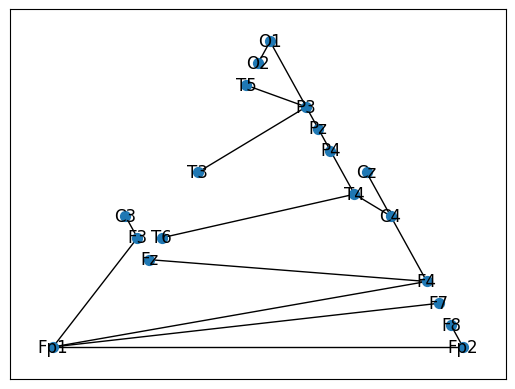

In [36]:
g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])
mst_g0 = nx.minimum_spanning_tree(g0)

nx.draw_networkx(
    mst_g0,
    nx.planar_layout(mst_g0),
    node_size=50
)

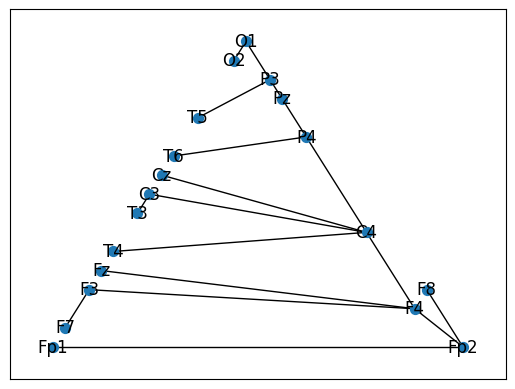

In [38]:
def get_mst(path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(path, sep=';')

    df['EEG channels'] = CHANNELS
    df = df.set_index('EEG channels')

    df = np.transpose(df)

    # Hacer la matriz de correlación
    df_correlation: pd.DataFrame = df.corr()

    # Hacer la matriz de distancias a partir de la correlación
    df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])
    return nx.minimum_spanning_tree(g0)

mst_g1 = get_mst('Archivos\\Subject00\\csv\\Subject00_2.csv')
nx.draw_networkx(
    mst_g1,
    nx.planar_layout(mst_g1),
    node_size=50
)

In [ ]:
density = nx.density(mst_g0)
ave_clustering = nx.average_clustering(mst_g0)

print(f'Density: {density}')
print(f'Average clustering: {ave_clustering}\n')

degree_centrality = nx.degree_centrality(mst_g0)
print('Degree centrality:')
pprint(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

betweenness_centrality = nx.betweenness_centrality(mst_g0)
print('\nBetweness centrality')
pprint(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

closeness_centrality = nx.closeness_centrality(mst_g0)
print('\nClossenes centrality')
pprint(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
print('\nPagerank')
pprint(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

In [ ]:
# Datos para sacar los diagrama de barras para cada medida de centralidad
df_centrality = pd.DataFrame({
    'nodes': CHANNELS,
    'degree': degree_centrality.values(),
    'betweenness': betweenness_centrality.values(),
    'closeness': closeness_centrality.values(),
    'pagerank': pagerank.values()
})

df_centrality

In [85]:
# Guarda las medidas de centralidad de los sujetos (antes y despues) en archivos

df_subject_info = pd.read_csv('Archivos\subject-info.csv')[['Subject', 'Count quality']]
df_before = pd.DataFrame()
df_during = pd.DataFrame()

for i in range(0, 35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    df_temp1 = pd.DataFrame({'subject': [subject]*19})
    df_temp1 = pd.concat([df_temp1, centrality(csv_path1)], axis=1)
    df_temp1['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_before = pd.concat([df_before, df_temp1], ignore_index=True)

    df_temp2 = pd.DataFrame({'subject': [subject]*19})
    df_temp2 = pd.concat([df_temp2, centrality(csv_path2)], axis=1)
    df_temp2['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_during = pd.concat([df_during, df_temp2], ignore_index=True)

df_before.to_csv('Archivos\centrality_before.csv', sep=';', index=False)
df_before.to_csv('Archivos\centrality_during.csv', sep=';', index=False)

In [86]:
df_before = pd.read_csv('Archivos\centrality_before.csv', delimiter=';')
df_before['state'] = 'before'

df_during = pd.read_csv('Archivos\centrality_during.csv', delimiter=';')
df_during['state'] = 'during'

df_result = pd.concat([df_before, df_during], ignore_index=True)
df_result

,subject,nodes,degree,betweenness,closeness,pagerank,count_quality,state
0,Subject00,Fp1,0.222222,0.477124,0.272727,0.094415,B,before
1,Subject00,Fp2,0.111111,0.111111,0.222222,0.053917,B,before
2,Subject00,F3,0.111111,0.111111,0.222222,0.054822,B,before
3,Subject00,F4,0.166667,0.542484,0.305085,0.071434,B,before
4,Subject00,F7,0.055556,0.000000,0.216867,0.040555,B,before
...,...,...,...,...,...,...,...,...
1363,Subject35,O1,0.055556,0.000000,0.180000,0.032810,G,during
1364,Subject35,O2,0.111111,0.111111,0.216867,0.053707,G,during
1365,Subject35,Fz,0.222222,0.542484,0.360000,0.089719,G,during
1366,Subject35,Cz,0.055556,0.000000,0.240000,0.031004,G,during


C:\Users\perez\AppData\Local\Temp\ipykernel_17180\1455375581.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


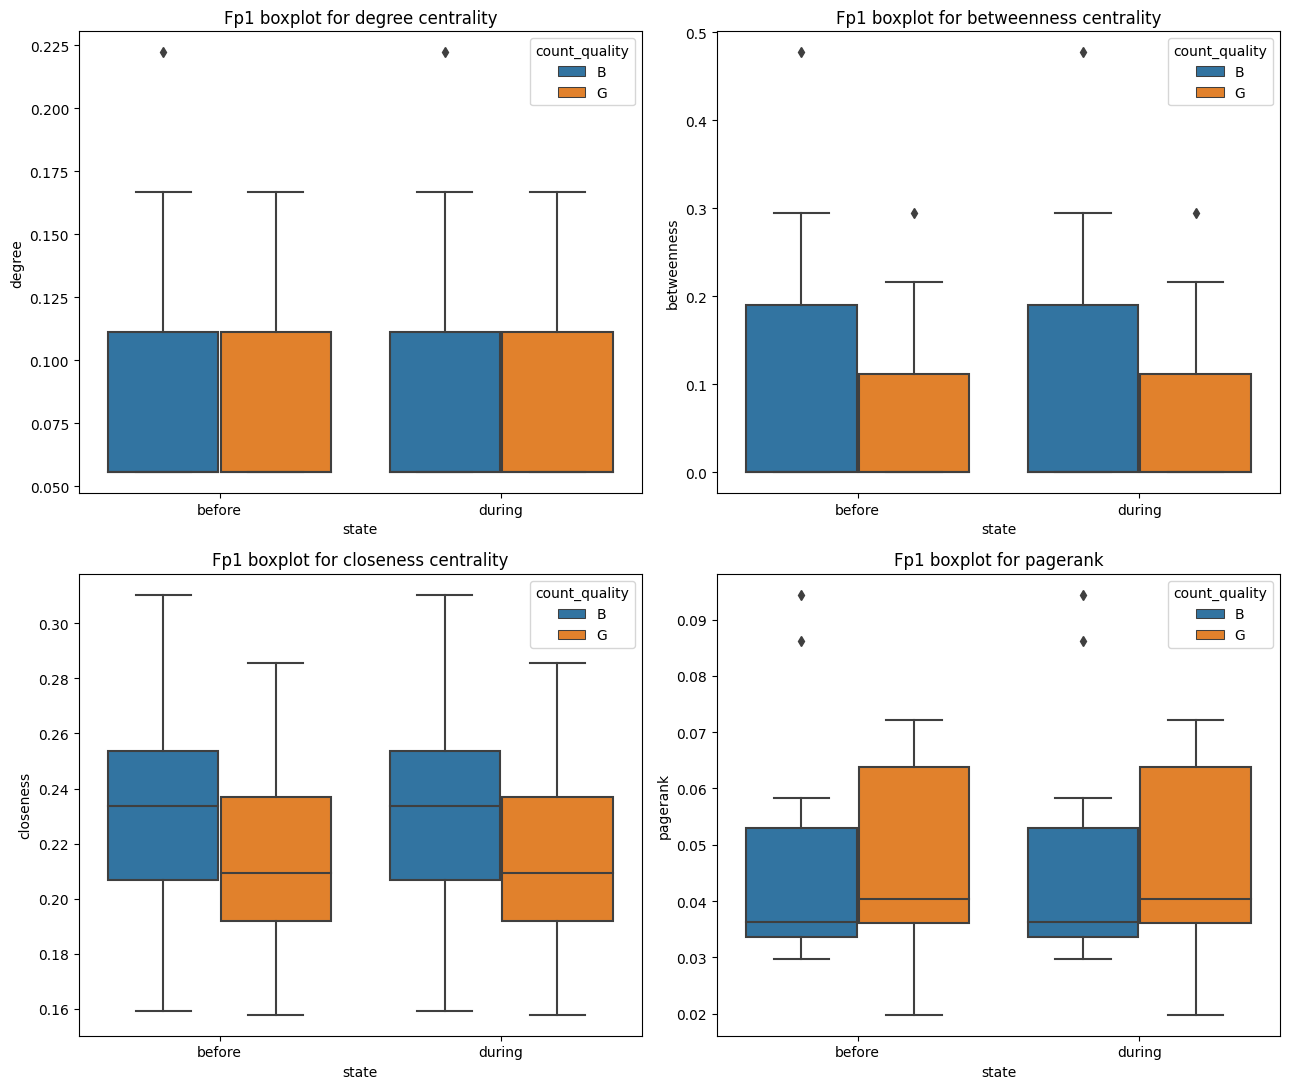

In [113]:
# Todas las gráficas de Fp1 para cada métrica diferente
sensor: str = 'Fp1'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()

C:\Users\perez\AppData\Local\Temp\ipykernel_17180\603923402.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


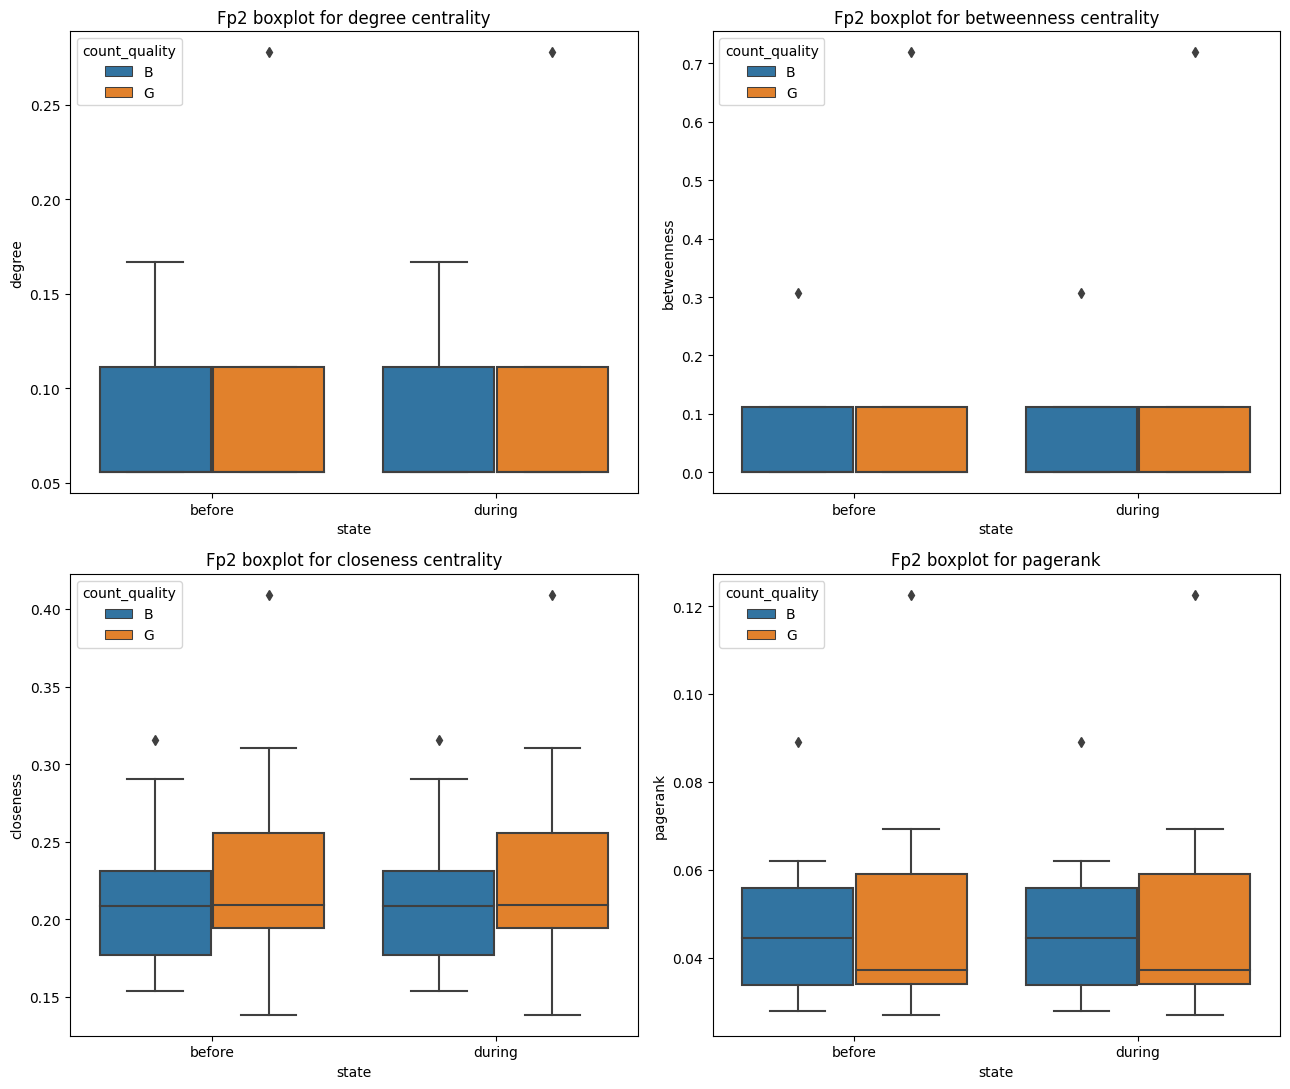

In [114]:
# Todas las gráficas de Fp2 para cada métrica diferente

sensor: str = 'Fp2'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()

C:\Users\perez\AppData\Local\Temp\ipykernel_17180\2654773774.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


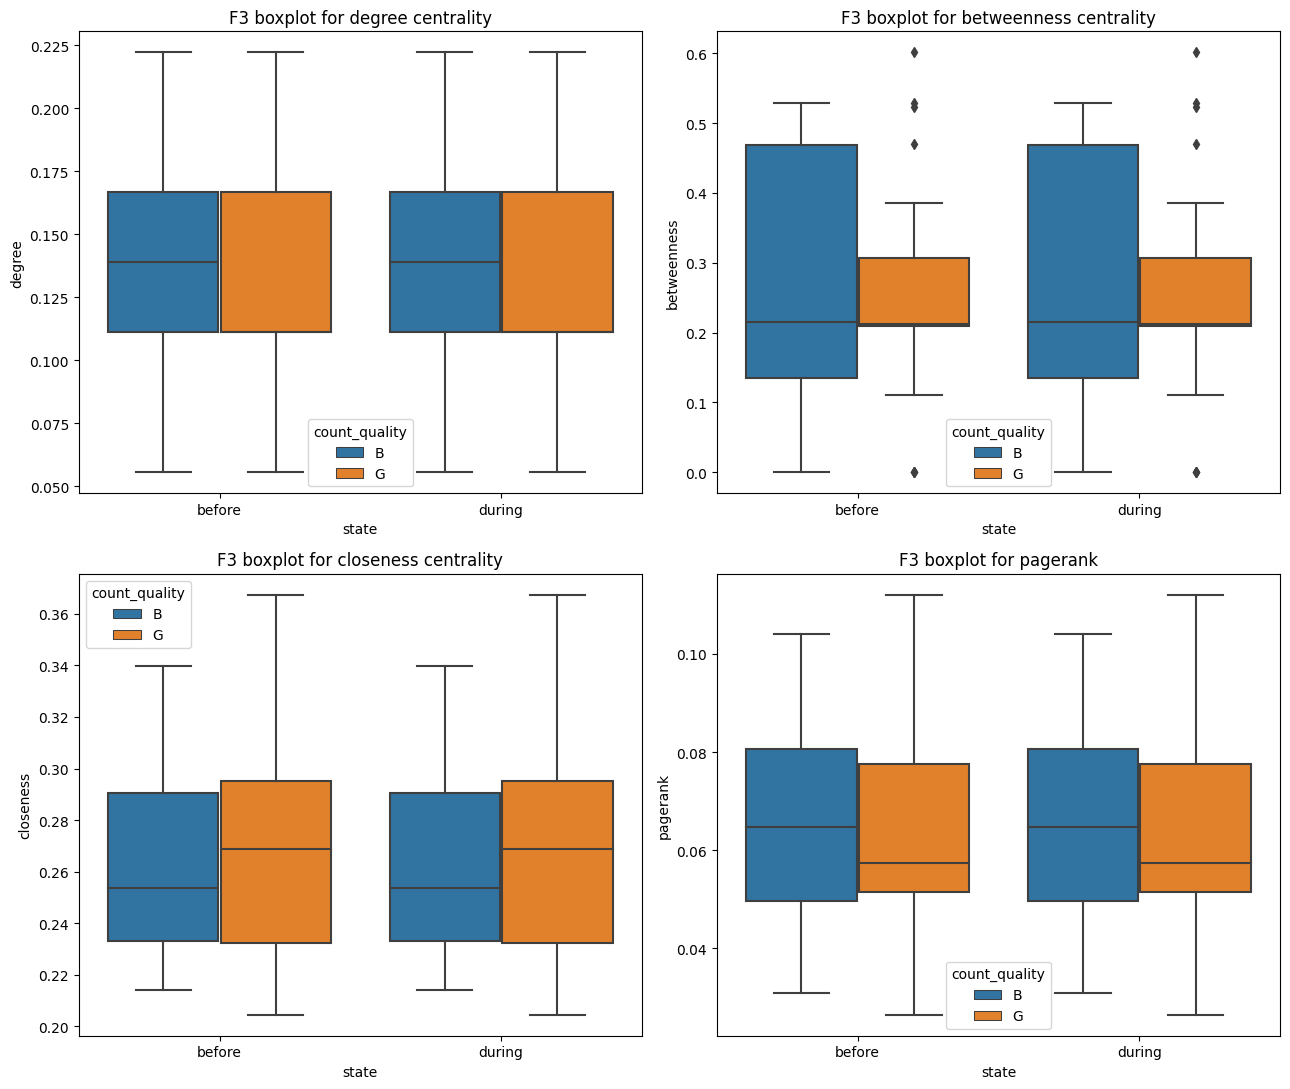

In [117]:
# Todas las gráficas de F3 para cada métrica diferente

sensor: str = 'F3'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()

C:\Users\perez\AppData\Local\Temp\ipykernel_17180\2346353104.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


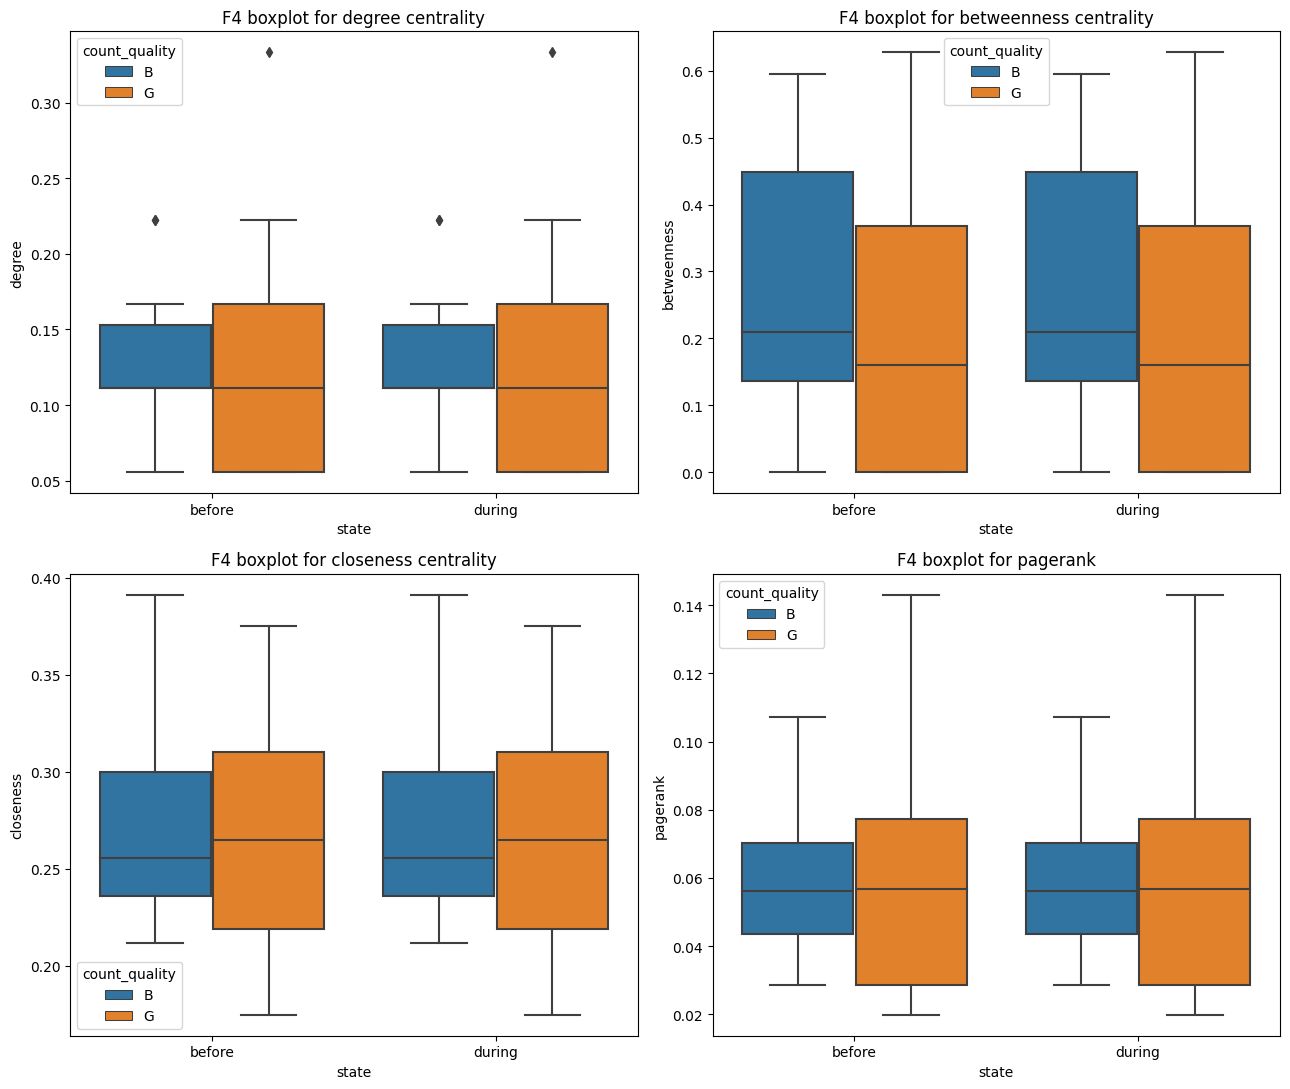

In [118]:
# Todas las gráficas de F4 para cada métrica diferente

sensor: str = 'F4'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()

C:\Users\perez\AppData\Local\Temp\ipykernel_17180\2021827967.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


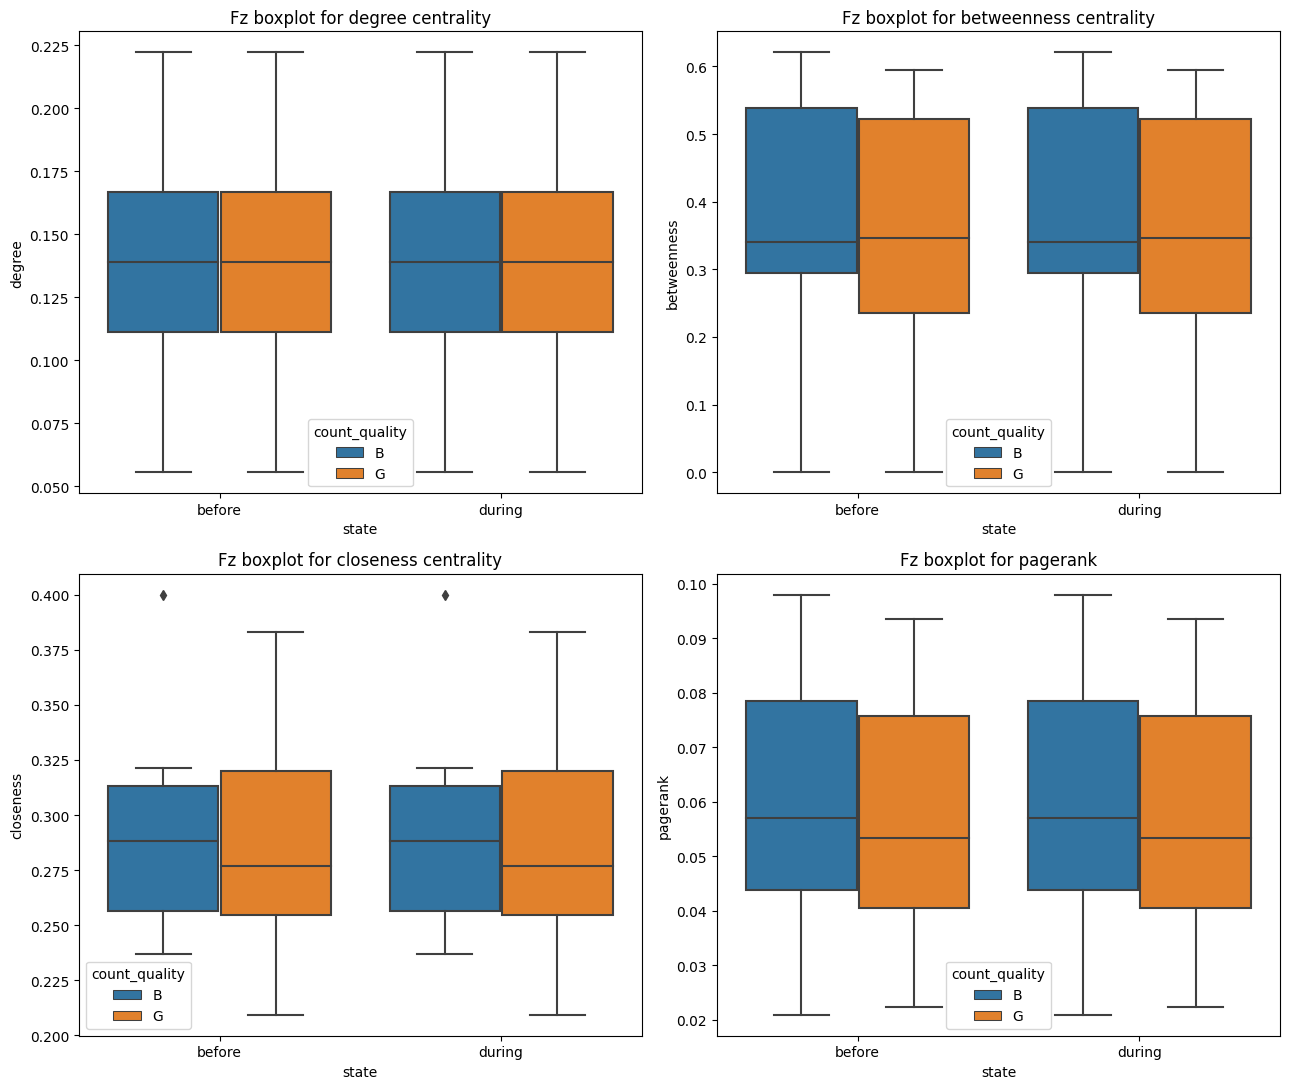

In [119]:
# Todas las gráficas de Fz para cada métrica diferente

sensor: str = 'Fz'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()

C:\Users\perez\AppData\Local\Temp\ipykernel_17180\3115180822.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


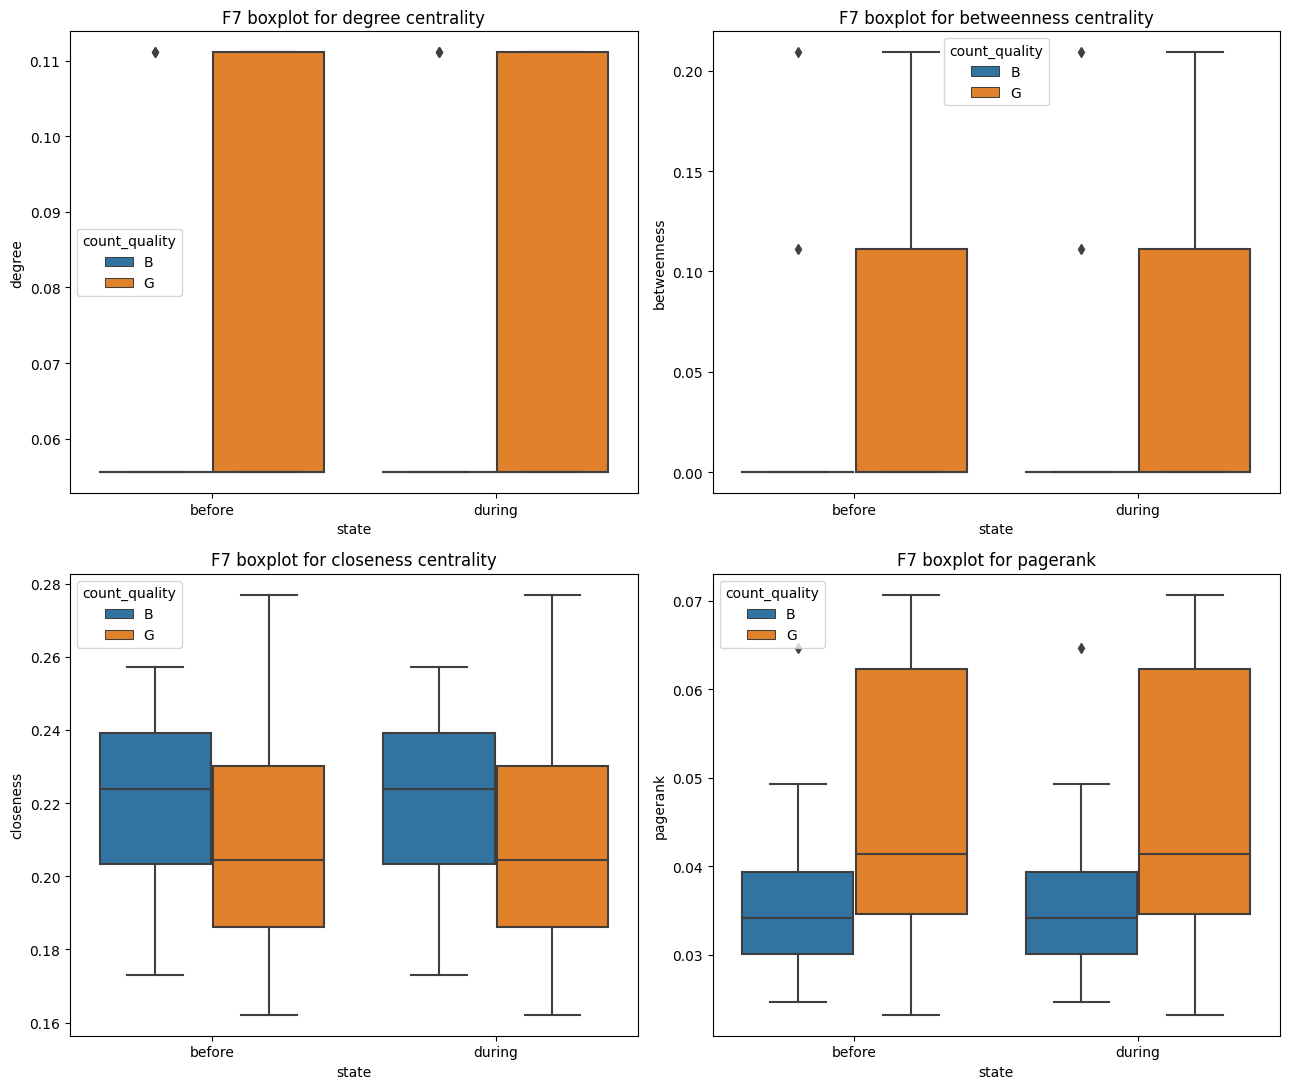

In [120]:
# Todas las gráficas de F7 para cada métrica diferente

sensor: str = 'F7'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()

C:\Users\perez\AppData\Local\Temp\ipykernel_17180\1525163286.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


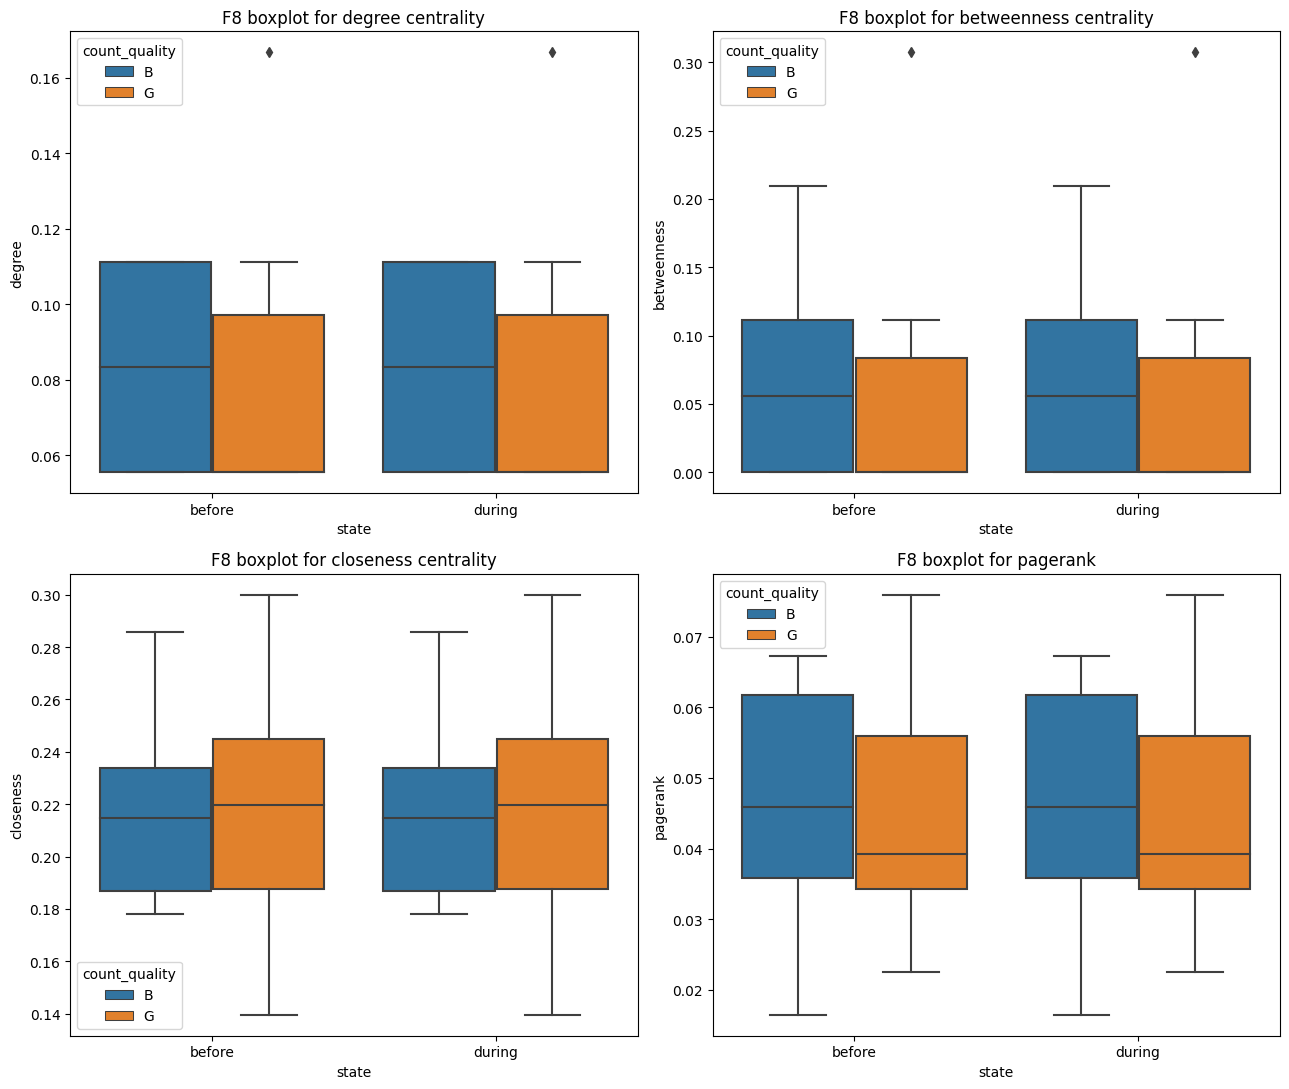

In [121]:
# Todas las gráficas de F8 para cada métrica diferente

sensor: str = 'F8'
df_sensor = df_result[df_result['nodes'] == sensor]
plt.subplots(figsize=(13, 11))

plt.subplot(2, 2, 1)
plt.title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality'
)

plt.subplot(2, 2, 2)
plt.title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality'
)

plt.subplot(2, 2, 3)
plt.title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality'
)

plt.subplot(2, 2, 4)
plt.title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality'
)

plt.tight_layout()